# Input Formatting

In [1]:
# Load necessary libraries
library(Signac)
library(Seurat)
library(GenomicRanges)
library(dplyr)

#----------------------#
# Configuration Setup #
#----------------------#

chosen_weeks = c(8.6, 8.8, 9)
gender = 'female'

#----------------------#


# male sample time map
# Mapping from sample ID to developmental timepoint
male_sample_time_map <- list(
  FCA_GND9332157 = 17,
  FCA_GND8768487 = 12,
  FCA_GND8795928 = 12,
  FCA_GND8795927 = 7,
  FCA_GND8768482 = 9, 
  FCA_GND8768481 = 19,
  HD_F_GON9883958 = 21,
  HD_F_GON9479872 = 15 # more files added after this line
)

female_sample_time_map <- list(
  FCA_GND8046539 = 8.8,
  FCA_GND8768484 = 8.6,
  FCA_GND8768485 = 9 # more files added after this line
)


male_sample_paths <- list(
  FCA_GND8046539 = "/group/tran3/gchahal/Garcia_et_all_FASTqs/male/FCAGND8046539/outs/",
  FCA_GND8768484 = "/group/tran3/gchahal/Garcia_et_all_FASTqs/male/FCAGND8768484/outs/",
  FCA_GND8768485 = "/group/tran3/gchahal/Garcia_et_all_FASTqs/male/FCAGND8768485/outs/",
  FCA_GND8795928 = "/group/tran3/gchahal/Garcia_et_all_FASTqs/male/FCAGND8795928/outs/",
  FCA_GND9332157 = "/group/tran3/gchahal/Garcia_et_all_FASTqs/male/FCAGND9332157/outs/" # more files added after this line
)

female_sample_paths <- list(
  FCA_GND8046539 = "/group/tran3/gchahal/Garcia_et_all_FASTqs/female/FCAGND8046539/outs/",
  FCA_GND8768484 = "/group/tran3/gchahal/Garcia_et_all_FASTqs/female/FCAGND8768484/outs/",
  FCA_GND8768485 = "/group/tran3/gchahal/Garcia_et_all_FASTqs/female/FCAGND8768485/outs/" # more files added after this line
)


#--------------------------------#
# Helper: Filter by timepoints   #
#--------------------------------#
filter_samples_by_weeks <- function(weeks, timemap) {
  selected <- names(Filter(function(w) w %in% weeks, timemap))
  return(selected)
}

#--------------------------------#
# Helper: Read & combine peaks   #
#--------------------------------#
# fix code here
read_and_process_peak_files <- function(sample_ids, sample_paths, min_threshold = 20, max_threshold = 10000) {
  cat("sample_ids inside function:", paste(sample_ids, collapse = ", "), "\n")
  cat("sample_paths inside function:", paste(sample_paths, collapse = ", "), "\n")
    
    
  gr_list <- lapply(sample_ids, function(id) {
    cat("sample_paths[[id]]:", paste(sample_paths[[id]], collapse = ", "), "\n")
      
    path <- paste0(sample_paths[[id]], "peaks.bed")
    cat("path:", paste(path, collapse = ", "), "\n")
      
    if (!file.exists(path)) return(NULL)
    peaks <- read.table(path, col.names = c("chr", "start", "end"))
    
    makeGRangesFromDataFrame(peaks)
  })
  combined.peaks <- reduce(do.call(c, gr_list))
  combined.peaks <- combined.peaks[width(combined.peaks) > min_threshold & width(combined.peaks) < max_threshold]
  return(combined.peaks)
}

#------------------------------#
# Build Seurat Object per ID  #
#------------------------------#
create_seurat_obj <- function(sample_id, combined_peaks, sample_paths) {
  path <- sample_paths[[sample_id]]
  cat("path:", path, "\n")
  
  md <- read.table(
    file = paste0(path, "singlecell.csv"),
    stringsAsFactors = FALSE, sep = ",", header = TRUE, row.names = 1
  )[-1, ]
  md <- md[md$passed_filters > 500, ]
  cat("metadata shape:", dim(md), "\n")  # rows = cells, cols = metadata fields
  
  frags <- CreateFragmentObject(path = paste0(path, "fragments.tsv.gz"), cells = rownames(md))
  
  counts <- FeatureMatrix(fragments = frags, features = combined_peaks, cells = rownames(md))
  cat("counts shape:", dim(counts), "\n")  # rows = peaks, cols = cells
  
  chrom_assay <- CreateChromatinAssay(counts, fragments = frags)
  obj <- CreateSeuratObject(chrom_assay, assay = "ATAC", meta.data = md)
  obj$dataset <- sample_id
  cat("Seurat object shape:", dim(obj), "\n")  # rows = peaks, cols = cells
  
  return(obj)
}

#------------------------------#
# Add cell type annotations   #
#------------------------------#
annotate_cells <- function(seurat_obj, sample_id, annot_file = "/group/tran3/gchahal/Garcia_et_all_FASTqs/atac_metadata.csv") {
  cat(paste(rep("*", 100), collapse = ""), "\n")

  # 1. Read and preprocess annotation file
  annotations <- read.table(annot_file, header = TRUE, sep = ',')
  cat("[INFO] Loaded annotations:", nrow(annotations), "rows\n")
  annotations$X <- sub("^\\d{2}-", "", annotations$X)

  # 2. Filter for current sample
  subset_ann <- subset(annotations, sample == sample_id)
  cat("[INFO] Annotations for", sample_id, ":", nrow(subset_ann), "rows\n")

  # 3. Prepare annotation vector
  cell_ids <- colnames(seurat_obj)
  cat("[INFO] Seurat object contains", length(cell_ids), "cells\n")

  cell_type_vector <- setNames(rep("missing", length(cell_ids)), cell_ids)
  matched_ids <- subset_ann$X %in% cell_ids
  matched_cells <- subset_ann$X[matched_ids]
  matched_types <- subset_ann$cell_type[matched_ids]

  cat("[INFO] Matching annotation rows:", sum(matched_ids), "\n")
  cell_type_vector[matched_cells] <- matched_types

  # 4. Add metadata
  seurat_obj <- AddMetaData(seurat_obj, metadata = cell_type_vector, col.name = "cell_type")

  # 5. Print sorted cell type frequency
  cat("\n[INFO] Cell type frequency (sorted):\n")
  print(sort(table(seurat_obj$cell_type), decreasing = TRUE))

  # 6. Check fragment object
  cat("\n[INFO] Fragment object:\n")
  print(Fragments(seurat_obj)[[1]])

  # 7. Check ATAC count matrix dimensions
  cat("\n[INFO] ATAC count matrix dimensions:\n")
  print(dim(GetAssayData(seurat_obj, assay = "ATAC", slot = "counts")))

  # 8. Check for empty metadata columns
  meta <- seurat_obj@meta.data
  empty_cols <- sapply(meta, function(x) all(is.na(x) | x == ""))
  if (any(empty_cols)) {
    cat("\n[WARNING] Empty metadata columns:\n")
    print(names(meta)[empty_cols])
  } else {
    cat("\n[INFO] No empty metadata columns found.\n")
  }

  # 9. Print Seurat object
  cat("\n[INFO] Final Seurat object summary:\n")
  print(seurat_obj)

  cat(paste(rep("*", 10), collapse = ""), "\n")

  return(seurat_obj)
}


#------------------------------#
# Full Pipeline Function      #
#------------------------------#
process_atac_pipeline <- function(weeks, timemap, sample_paths) {
  sample_ids <- filter_samples_by_weeks(weeks, timemap)
  cat("sample_ids:", paste(sample_ids, collapse = ", "), "\n")
  cat("sample_paths:", paste(sample_paths, collapse = ", "), "\n")
    
  combined_peaks <- read_and_process_peak_files(sample_ids, sample_paths)
  cat("Combined peaks:\n")
  print(combined_peaks)
  
  objs <- list()
  for (id in sample_ids) {
    cat("\nProcessing:", id, "\n")
    
    obj <- create_seurat_obj(id, combined_peaks, sample_paths)
    cat("Created Seurat object:\n")
    print(obj)
    
    obj <- annotate_cells(obj, id)
    cat("Annotated Seurat object:\n")
    print(obj)
    
    objs[[id]] <- obj
  }

  cat("Merging Seurat objects...\n")
  merged <- Reduce(function(x, y) merge(x, y, add.cell.ids = c(x$dataset[1], y$dataset[1])), objs)
  cat("Final merged object:\n")
  print(merged)

  return(merged)
}


# Load required packages
library(Signac)
library(Seurat)
library(GenomicRanges)
library(data.table)

# Run the pipeline
# if gender == 'female', proceed this otherwise, proceed for male 
combined_ovary <- process_atac_pipeline(weeks = chosen_weeks,
                                        timemap = female_sample_time_map,
                                        sample_paths = female_sample_paths)

if (gender == "female") {
  combined_ovary <- process_atac_pipeline(
    weeks = chosen_weeks,
    timemap = female_sample_time_map,
    sample_paths = female_sample_paths
  )
  combined <- combined_ovary
} else if (gender == "male") {
  combined_testis <- process_atac_pipeline(
    weeks = chosen_weeks,
    timemap = male_sample_time_map,
    sample_paths = male_sample_paths
  )
  combined <- combined_testis
} else {
  stop("Invalid gender. Must be 'male' or 'female'.")
}



Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following 

sample_ids: FCA_GND8046539, FCA_GND8768484, FCA_GND8768485 
sample_paths: /group/tran3/gchahal/Garcia_et_all_FASTqs/female/FCAGND8046539/outs/, /group/tran3/gchahal/Garcia_et_all_FASTqs/female/FCAGND8768484/outs/, /group/tran3/gchahal/Garcia_et_all_FASTqs/female/FCAGND8768485/outs/ 
sample_ids inside function: FCA_GND8046539, FCA_GND8768484, FCA_GND8768485 
sample_paths inside function: /group/tran3/gchahal/Garcia_et_all_FASTqs/female/FCAGND8046539/outs/, /group/tran3/gchahal/Garcia_et_all_FASTqs/female/FCAGND8768484/outs/, /group/tran3/gchahal/Garcia_et_all_FASTqs/female/FCAGND8768485/outs/ 
sample_paths[[id]]: /group/tran3/gchahal/Garcia_et_all_FASTqs/female/FCAGND8046539/outs/ 
path: /group/tran3/gchahal/Garcia_et_all_FASTqs/female/FCAGND8046539/outs/peaks.bed 
sample_paths[[id]]: /group/tran3/gchahal/Garcia_et_all_FASTqs/female/FCAGND8768484/outs/ 
path: /group/tran3/gchahal/Garcia_et_all_FASTqs/female/FCAGND8768484/outs/peaks.bed 
sample_paths[[id]]: /group/tran3/gchahal/Garcia_et

Computing hash

Extracting reads overlapping genomic regions



counts shape: 202606 11049 
Seurat object shape: 202606 11049 
Created Seurat object:
An object of class Seurat 
202606 features across 11049 samples within 1 assay 
Active assay: ATAC (202606 features, 0 variable features)
 2 layers present: counts, data
**************************************************************************************************** 
[INFO] Loaded annotations: 136916 rows
[INFO] Annotations for FCA_GND8046539 : 8314 rows
[INFO] Seurat object contains 11049 cells
[INFO] Matching annotation rows: 8314 

[INFO] Cell type frequency (sorted):

       Supporting      preGranulosa           missing  Mesenchymal_LHX9 
             2969              2961              2735              1250 
          CoelEpi Mesenchymal_GATA2       Endothelial                PV 
              493               430                85                71 
        GermCells            Immune        Epithelial 
               42                 9                 4 

[INFO] Fragment object:
A Frag

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”


[1] 202606  11049

[INFO] No empty metadata columns found.

[INFO] Final Seurat object summary:
An object of class Seurat 
202606 features across 11049 samples within 1 assay 
Active assay: ATAC (202606 features, 0 variable features)
 2 layers present: counts, data
********** 
Annotated Seurat object:
An object of class Seurat 
202606 features across 11049 samples within 1 assay 
Active assay: ATAC (202606 features, 0 variable features)
 2 layers present: counts, data

Processing: FCA_GND8768484 
path: /group/tran3/gchahal/Garcia_et_all_FASTqs/female/FCAGND8768484/outs/ 
metadata shape: 4170 17 


Computing hash

Extracting reads overlapping genomic regions



counts shape: 202606 4170 
Seurat object shape: 202606 4170 
Created Seurat object:
An object of class Seurat 
202606 features across 4170 samples within 1 assay 
Active assay: ATAC (202606 features, 0 variable features)
 2 layers present: counts, data
**************************************************************************************************** 
[INFO] Loaded annotations: 136916 rows
[INFO] Annotations for FCA_GND8768484 : 3433 rows
[INFO] Seurat object contains 4170 cells
[INFO] Matching annotation rows: 3433 

[INFO] Cell type frequency (sorted):

Mesenchymal_GATA2           missing        Supporting            Neural 
             1637               737               533               333 
          CoelEpi      preGranulosa  Mesenchymal_LHX9                PV 
              259               218               127                85 
       Epithelial       Endothelial            Immune         GermCells 
               77                67                52                41 

Computing hash

Extracting reads overlapping genomic regions



counts shape: 202606 6767 
Seurat object shape: 202606 6767 
Created Seurat object:
An object of class Seurat 
202606 features across 6767 samples within 1 assay 
Active assay: ATAC (202606 features, 0 variable features)
 2 layers present: counts, data
**************************************************************************************************** 
[INFO] Loaded annotations: 136916 rows
[INFO] Annotations for FCA_GND8768485 : 4760 rows
[INFO] Seurat object contains 6767 cells
[INFO] Matching annotation rows: 4750 

[INFO] Cell type frequency (sorted):

          missing Mesenchymal_GATA2      preGranulosa        Supporting 
             2017              1468              1016               915 
          CoelEpi  Mesenchymal_LHX9        Epithelial                PV 
              459               241               181               180 
        GermCells       Endothelial            Immune            Neural 
              135                82                59                11 

Computing hash

Extracting reads overlapping genomic regions



counts shape: 202606 11049 
Seurat object shape: 202606 11049 
Created Seurat object:
An object of class Seurat 
202606 features across 11049 samples within 1 assay 
Active assay: ATAC (202606 features, 0 variable features)
 2 layers present: counts, data
**************************************************************************************************** 
[INFO] Loaded annotations: 136916 rows
[INFO] Annotations for FCA_GND8046539 : 8314 rows
[INFO] Seurat object contains 11049 cells
[INFO] Matching annotation rows: 8314 

[INFO] Cell type frequency (sorted):

       Supporting      preGranulosa           missing  Mesenchymal_LHX9 
             2969              2961              2735              1250 
          CoelEpi Mesenchymal_GATA2       Endothelial                PV 
              493               430                85                71 
        GermCells            Immune        Epithelial 
               42                 9                 4 

[INFO] Fragment object:
A Frag

Computing hash

Extracting reads overlapping genomic regions



counts shape: 202606 4170 
Seurat object shape: 202606 4170 
Created Seurat object:
An object of class Seurat 
202606 features across 4170 samples within 1 assay 
Active assay: ATAC (202606 features, 0 variable features)
 2 layers present: counts, data
**************************************************************************************************** 
[INFO] Loaded annotations: 136916 rows
[INFO] Annotations for FCA_GND8768484 : 3433 rows
[INFO] Seurat object contains 4170 cells
[INFO] Matching annotation rows: 3433 

[INFO] Cell type frequency (sorted):

Mesenchymal_GATA2           missing        Supporting            Neural 
             1637               737               533               333 
          CoelEpi      preGranulosa  Mesenchymal_LHX9                PV 
              259               218               127                85 
       Epithelial       Endothelial            Immune         GermCells 
               77                67                52                41 

Computing hash

Extracting reads overlapping genomic regions



counts shape: 202606 6767 
Seurat object shape: 202606 6767 
Created Seurat object:
An object of class Seurat 
202606 features across 6767 samples within 1 assay 
Active assay: ATAC (202606 features, 0 variable features)
 2 layers present: counts, data
**************************************************************************************************** 
[INFO] Loaded annotations: 136916 rows
[INFO] Annotations for FCA_GND8768485 : 4760 rows
[INFO] Seurat object contains 6767 cells
[INFO] Matching annotation rows: 4750 

[INFO] Cell type frequency (sorted):

          missing Mesenchymal_GATA2      preGranulosa        Supporting 
             2017              1468              1016               915 
          CoelEpi  Mesenchymal_LHX9        Epithelial                PV 
              459               241               181               180 
        GermCells       Endothelial            Immune            Neural 
              135                82                59                11 

In [2]:
# library(Signac)
# library(GenomicRanges)
library(Seurat)
library(dplyr)


In [3]:
combined_ovary

An object of class Seurat 
202606 features across 21986 samples within 1 assay 
Active assay: ATAC (202606 features, 0 variable features)
 2 layers present: counts, data

# QC Filtering

In [4]:
pbmc = combined_ovary
# peaks not found in this seurat object
pbmc[['ATAC']]
# granges(pbmc)

peaks.keep <- seqnames(granges(pbmc)) %in% standardChromosomes(granges(pbmc))
pbmc <- pbmc[as.vector(peaks.keep), ]

library(AnnotationHub)
library(biovizBase)
library(ensembldb)
# Load necessary libraries
library(Signac)
library(Seurat)
library(GenomicRanges)
library(dplyr)
ah <- AnnotationHub()

# Search for the Ensembl 98 EnsDb for Homo sapiens on AnnotationHub
query(ah, "EnsDb.Hsapiens.v98")

ensdb_v98 <- ah[["AH75011"]]
# # extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = ensdb_v98)

# change to UCSC style since the data was mapped to hg38
seqlevels(annotations) <- paste0('chr', seqlevels(annotations))
genome(annotations) <- "hg38"
# add the gene information to the object
Annotation(pbmc) <- annotations
pbmc

ChromatinAssay data with 202606 features for 21986 cells
Variable features: 0 
Genome: 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 3 

Loading required package: BiocFileCache

Loading required package: dbplyr


Attaching package: ‘dbplyr’


The following objects are masked from ‘package:dplyr’:

    ident, sql


Loading required package: GenomicFeatures

Loading required package: AnnotationDbi

Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.



Attaching package: 'Biobase'


The following object is masked from 'package:AnnotationHub':

    cache



Attaching package: 'AnnotationDbi'


The following object is masked from 'package:dplyr':

    select


Loading required package: AnnotationFilter


Attaching package: 'ensembldb'


The following object is masked from 'package:dplyr':

    filter


The following object is masked from 'package:stats':

    filter




AnnotationHub with 1 record
# snapshotDate(): 2024-10-28
# names(): AH75011
# $dataprovider: Ensembl
# $species: Homo sapiens
# $rdataclass: EnsDb
# $rdatadateadded: 2019-05-02
# $title: Ensembl 98 EnsDb for Homo sapiens
# $description: Gene and protein annotations for Homo sapiens based on Ensem...
# $taxonomyid: 9606
# $genome: GRCh38
# $sourcetype: ensembl
# $sourceurl: http://www.ensembl.org
# $sourcesize: NA
# $tags: c("98", "AHEnsDbs", "Annotation", "EnsDb", "Ensembl", "Gene",
#   "Protein", "Transcript") 
# retrieve record with 'object[["AH75011"]]' 

loading from cache

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress 

An object of class Seurat 
202606 features across 21986 samples within 1 assay 
Active assay: ATAC (202606 features, 0 variable features)
 2 layers present: counts, data

In [5]:
# library(biovizBase)

# exists("GetGRangesFromEnsDb")
# # Should return TRUE
# ls("package:biovizBase", pattern = "GetGRanges")
# # BiocManager::install("GenomeInfoDb")
# library(GenomeInfoDb)

In [6]:
# compute nucleosome signal score per cell
pbmc <- NucleosomeSignal(object = pbmc)

# compute TSS enrichment score per cell
pbmc <- TSSEnrichment(object = pbmc)


Extracting TSS positions

Extracting fragments at TSSs

Warning message in cc + as.vector(x = counts.center):
"longer object length is not a multiple of shorter object length"
Warning message in cc[names(x = counts.center)] <- cc + as.vector(x = counts.center):
"number of items to replace is not a multiple of replacement length"
Warning message in fc + as.vector(x = counts.flank):
"longer object length is not a multiple of shorter object length"
Warning message in fc[names(x = counts.flank)] <- fc + as.vector(x = counts.flank):
"number of items to replace is not a multiple of replacement length"
Warning message in cc + as.vector(x = counts.center):
"longer object length is not a multiple of shorter object length"
Warning message in cc[names(x = counts.center)] <- cc + as.vector(x = counts.center):
"number of items to replace is not a multiple of replacement length"
Warning message in fc + as.vector(x = counts.flank):
"longer object length is not a multiple of shorter object length"
War

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,⋯,blacklist_region_fragments,peak_region_fragments,peak_region_cutsites,dataset,cell_type,nucleosome_signal,nucleosome_percentile,TSS.enrichment,TSS.percentile,pct_reads_in_peaks
,<chr>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FCA_GND8046539_FCA_GND8046539_AAACGAAAGGCTCCTG-1,SeuratProject,15000,12029,36223,9560,417,143,2772,1922,21409,⋯,0,15314,29809,FCA_GND8046539,Supporting,0.7360761,0.54,3.629091,0.41,71.53066
FCA_GND8046539_FCA_GND8046539_AAACGAAAGTCCAGAG-1,SeuratProject,20120,15621,51762,12124,550,162,4326,3299,31301,⋯,0,20227,39233,FCA_GND8046539,Supporting,0.8547212,0.76,3.104199,0.16,64.62094
FCA_GND8046539_FCA_GND8046539_AAACGAACAACGGGTA-1,SeuratProject,1597,1556,3577,695,15,9,208,67,2583,⋯,0,1629,3117,FCA_GND8046539,missing,2.0476190,1.00,2.721088,0.10,63.06620


An object of class Seurat 
202606 features across 21986 samples within 1 assay 
Active assay: ATAC (202606 features, 0 variable features)
 2 layers present: counts, data

Warning message:
"Removed 511 rows containing non-finite outside the scale range (`stat_bin()`)."
Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`)."


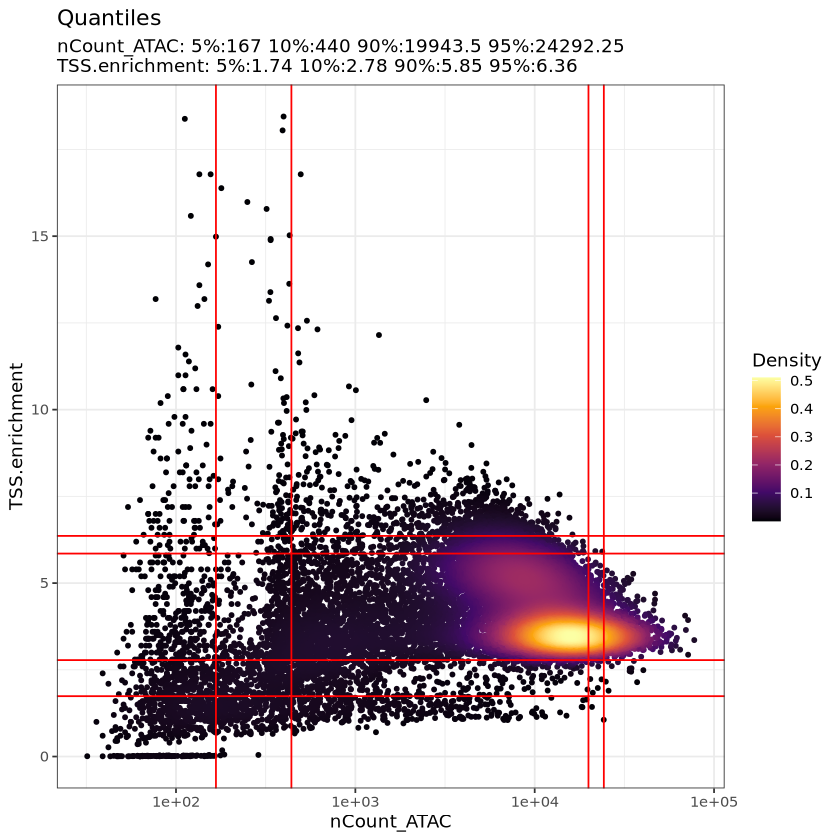

Warning message:
"The `slot` argument of `FetchData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>."
Warning message:
"`PackageCheck()` was deprecated in SeuratObject 5.0.0.
ℹ Please use `rlang::check_installed()` instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>."


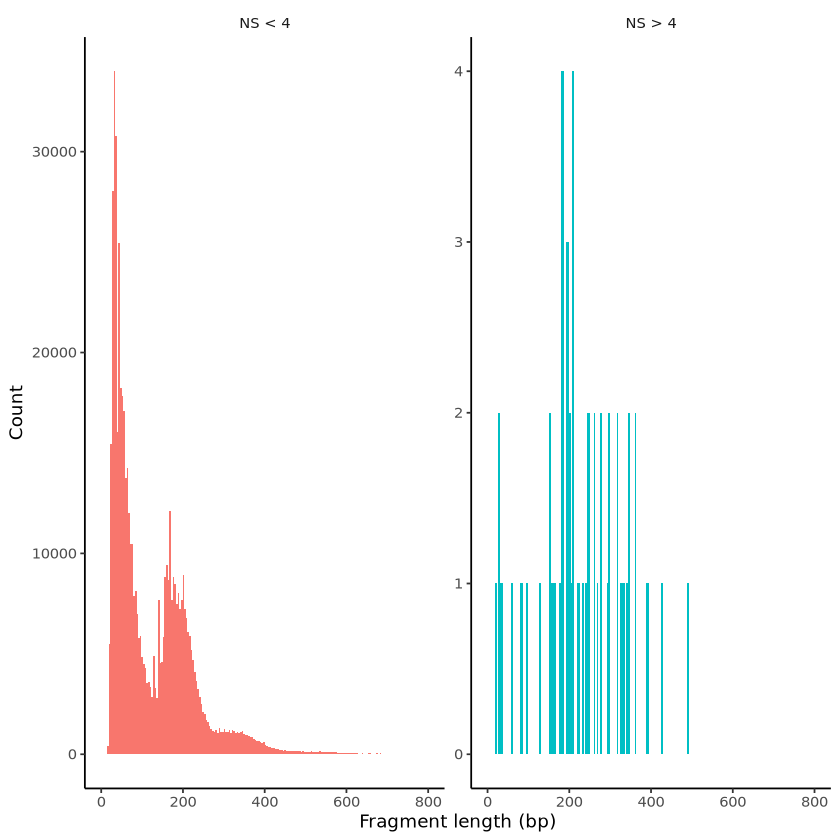

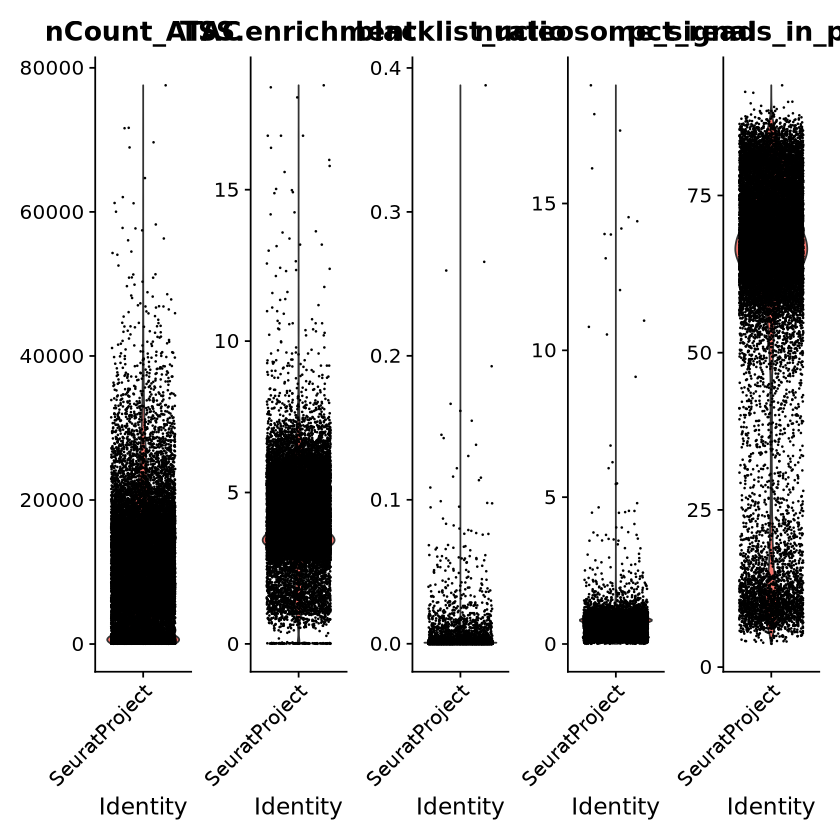

In [7]:

# add fraction of reads in peaks
pbmc$pct_reads_in_peaks <- pbmc$peak_region_fragments / pbmc$passed_filters * 100

head(pbmc,3)

# add blacklist ratio
pbmc$blacklist_ratio <- FractionCountsInRegion(
  object = pbmc, 
  assay = 'ATAC',
  regions = blacklist_hg38_unified
)

DensityScatter(pbmc, x = 'nCount_ATAC', y = 'TSS.enrichment', log_x = TRUE, quantiles = TRUE)

pbmc

pbmc$nucleosome_group <- ifelse(pbmc$nucleosome_signal > 4, 'NS > 4', 'NS < 4')
FragmentHistogram(object = pbmc, group.by = 'nucleosome_group')



VlnPlot(
  object = pbmc,
  features = c('nCount_ATAC', 'TSS.enrichment', 'blacklist_ratio', 'nucleosome_signal', 'pct_reads_in_peaks'),
  pt.size = 0.1,
  ncol = 5
)



In [8]:
# filtering
pbmc <- subset(
  x = pbmc,
  subset = nCount_ATAC > 9000 &
    nCount_ATAC < 100000 &
    pct_reads_in_peaks > 40 &
    blacklist_ratio < 0.01 &
    nucleosome_signal < 4 &
    TSS.enrichment > 4
)
pbmc

An object of class Seurat 
202606 features across 3893 samples within 1 assay 
Active assay: ATAC (202606 features, 0 variable features)
 2 layers present: counts, data

Warning message:
"Removed 64 rows containing non-finite outside the scale range (`stat_bin()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`)."


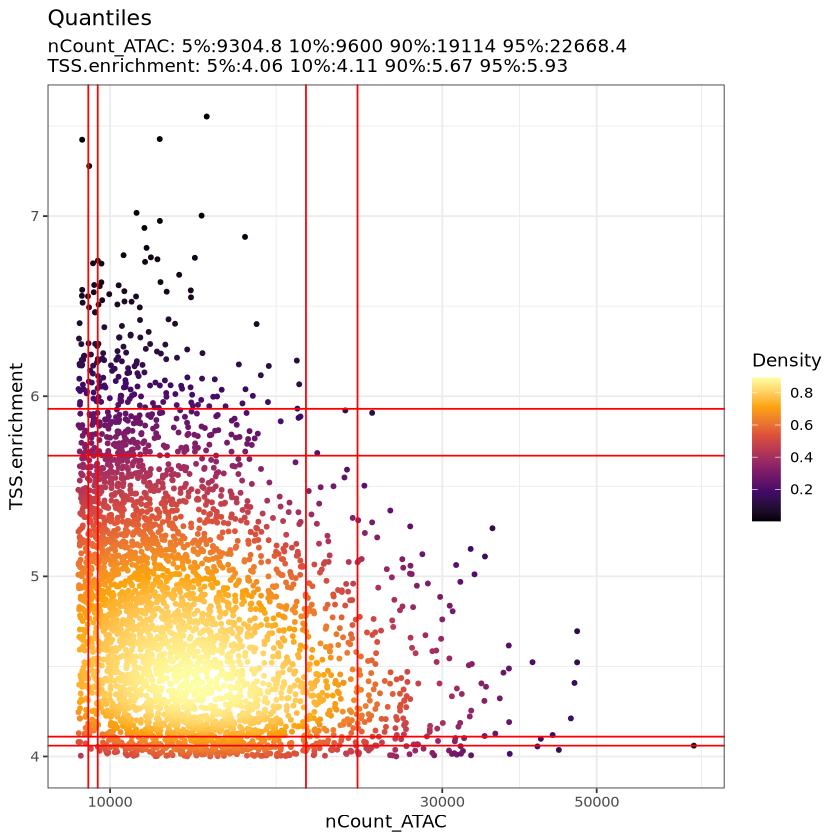

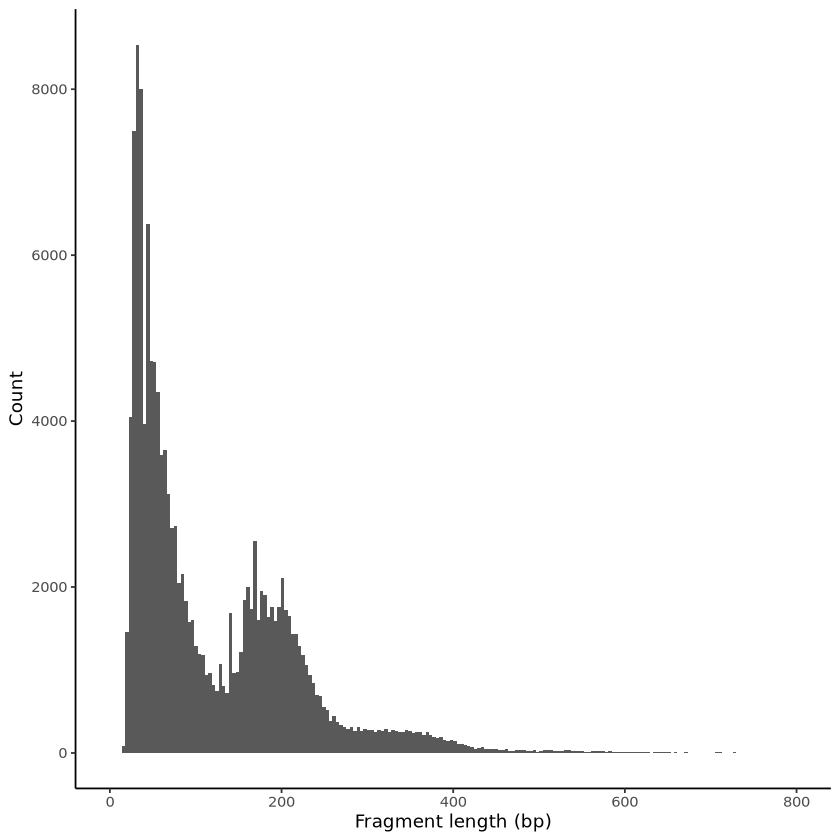

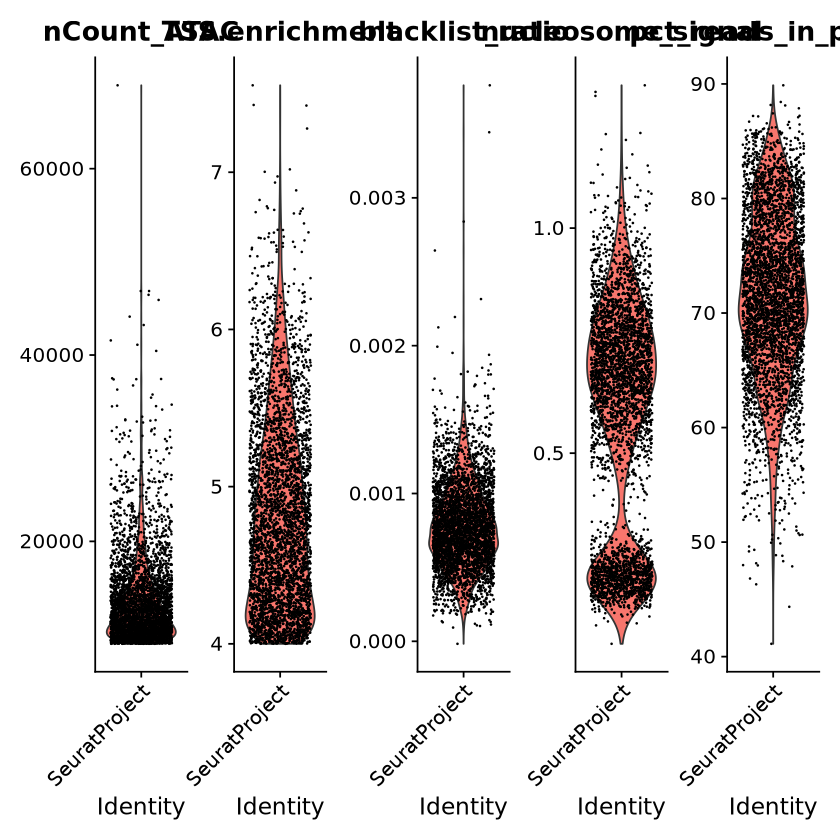

In [9]:

# add blacklist ratio
pbmc$blacklist_ratio <- FractionCountsInRegion(
  object = pbmc, 
  assay = 'ATAC',
  regions = blacklist_hg38_unified
)

DensityScatter(pbmc, x = 'nCount_ATAC', y = 'TSS.enrichment', log_x = TRUE, quantiles = TRUE)


pbmc$nucleosome_group <- ifelse(pbmc$nucleosome_signal > 4, 'NS > 4', 'NS < 4')
FragmentHistogram(object = pbmc, group.by = 'nucleosome_group')


VlnPlot(
  object = pbmc,
  features = c('nCount_ATAC', 'TSS.enrichment', 'blacklist_ratio', 'nucleosome_signal', 'pct_reads_in_peaks'),
  pt.size = 0.1,
  ncol = 5
)

# Downstream Analysis

## Dimensionality Reduction
Q75
Save object to seurat object (Note for file name: q75/q90/...)

In [11]:
pbmc

An object of class Seurat 
202606 features across 3893 samples within 1 assay 
Active assay: ATAC (202606 features, 0 variable features)
 2 layers present: counts, data

In [10]:
# chosen_weeks = c(8.6, 8.8, 9)
# gender = 'female'

library(Signac)
library(Seurat)
library(GenomicRanges)
library(Matrix)
library(future)
library(AnnotationHub)
library(irlba)
library(SeuratDisk)

# Save Seurat object to gender-specific filename
seurat_object_filepath <- paste0(
  "/group/tran3/gchahal/Garcia_et_all_FASTqs/",
  gender, "_seurat_obj_", paste(chosen_weeks, collapse = "_"), ".rds"
)
saveRDS(pbmc, file = seurat_object_filepath)
cat("Saved Seurat object to:", seurat_object_filepath, "\n")


seurat_obj <- readRDS(seurat_object_filepath)
seurat_obj

cat("Saved Seurat object to:", seurat_object_filepath, "\n")



Attaching package: 'Matrix'


The following object is masked from 'package:S4Vectors':

    expand



Attaching package: 'future'


The following object is masked from 'package:AnnotationFilter':

    value


Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat



Saved Seurat object to: /group/tran3/gchahal/Garcia_et_all_FASTqs/female_seurat_obj_8.6_8.8_9.rds 


An object of class Seurat 
202606 features across 3893 samples within 1 assay 
Active assay: ATAC (202606 features, 0 variable features)
 2 layers present: counts, data

Saved Seurat object to: /group/tran3/gchahal/Garcia_et_all_FASTqs/female_seurat_obj_8.6_8.8_9.rds 


Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, layer = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings



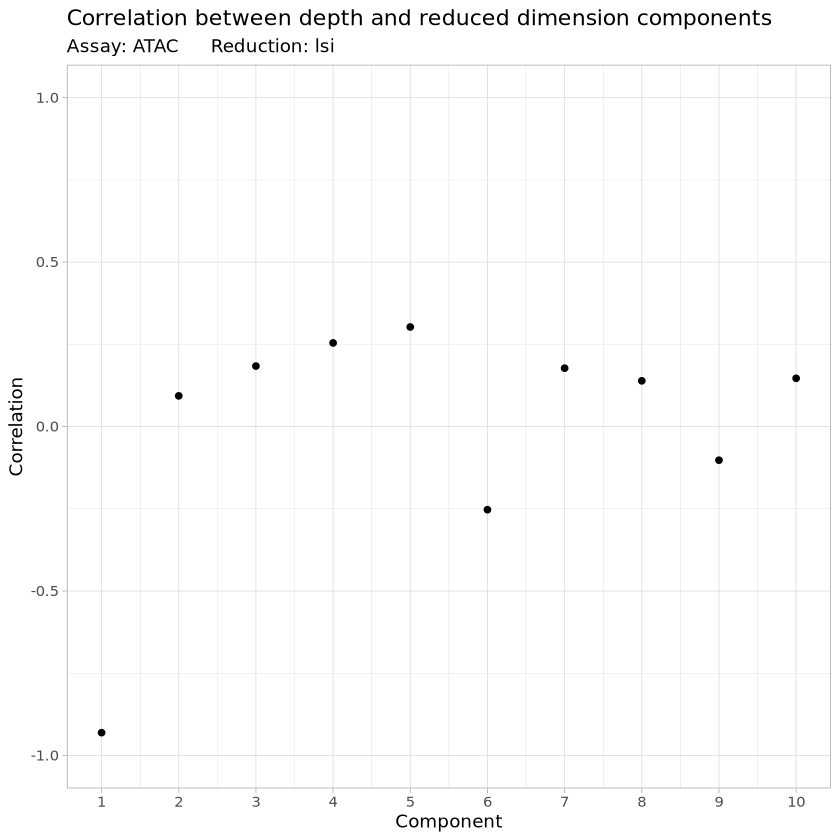

In [12]:


# # Save Seurat object to gender-specific filename
# seurat_object_filepath <- paste0(
#   "/group/tran3/gchahal/Garcia_et_all_FASTqs/",
#   gender, "_seurat_obj_", paste(chosen_weeks, collapse = "_"), ".rds"
# )
# saveRDS(pbmc, file = seurat_object_filepath)
# seurat_obj <- readRDS(seurat_object_filepath)

library(irlba)
library(Matrix)


seurat_obj <- RunTFIDF(seurat_obj)
seurat_obj <- FindTopFeatures(seurat_obj, min.cutoff = 'q75')
seurat_obj <- RunSVD(seurat_obj)

DepthCor(seurat_obj)


In [15]:


# # doesn't really need this
# # main difference between this pipeline and Signac_merge_pipeline and Draft.ipynb


# # be aware of yourself when running this pipeline
# # Load variable features
# var_peaks <- VariableFeatures(seurat_obj)

# # Convert "chr15-75449339-75457073" to a data frame with chr, start, end
# library(dplyr)
# library(tidyr)

# peak_df <- data.frame(peak = var_peaks) %>%
#   separate(peak, into = c("chr", "start", "end"), sep = "-", convert = TRUE)

# head(peak_df)
# # Read the BED file, this is from Hieu's input
# ovary_bed_file = "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas/ovary_bed_file.bed"
# bed <- read.table(ovary_bed_file, header = FALSE, sep = "\t", stringsAsFactors = FALSE)
# colnames(bed)[1:3] <- c("chr", "start", "end")

# # Inner join to get matching peaks
# filtered_bed <- inner_join(bed, peak_df, by = c("chr", "start", "end"))

# # View result
# head(filtered_bed)
# dim(filtered_bed)

# # # # Optionally save it
# # filtered_bed_file = "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas/q75_filtered_ovary_bed_file.bed"

# # write.table(filtered_bed, filtered_bed_file,
# #             sep = "\t", row.names = FALSE, col.names = FALSE, quote = FALSE)

# # q0: 181870
# # q25: 137074
# # q50: 91051
# # q75: 45504
# # q90: 18190


,chr,start,end
,<chr>,<int>,<int>
1,chr15,75449339,75457073
2,chr19,54186335,54192496
3,chr13,110711287,110718395
4,chr14,75276368,75285398
5,chr19,13148741,13158539
6,chr19,12787585,12797555


,chr,start,end,V4
,<chr>,<int>,<int>,<chr>
1,chr1,100034406,100040189,ovary_MesLHX9_preGran_MesGATA2_CoelEpi_Supp_Endo_PV_Missing_Epi_Neuro_Immune_SMC
2,chr1,100132201,100134031,ovary_preGran_Supp_MesLHX9_Endo_PV_MesGATA2_CoelEpi_Missing_Epi_Neuro_Immune_SMC_Germ
3,chr1,100188185,100189230,ovary_MesLHX9_MesGATA2_Missing_Supp_preGran_CoelEpi_PV_Epi_Neuro_Immune_Endo
4,chr1,100248816,100250672,ovary_MesGATA2_preGran_MesLHX9_Endo_PV_Supp_CoelEpi_Missing_Neuro_Immune_Germ_Epi_SMC
5,chr1,100265343,100267433,ovary_MesLHX9_MesGATA2_CoelEpi_preGran_Supp_Missing_Endo_Epi_PV_Neuro_Immune_Germ
6,chr1,1002991,1007037,ovary_MesLHX9_MesGATA2_CoelEpi_Missing_Supp_Endo_preGran_PV_Epi_Neuro_Immune


[1] 50735     4

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
15:21:04 UMAP embedding parameters a = 0.9922 b = 1.112

15:21:04 Read 3893 rows and found 29 numeric columns

15:21:04 Using Annoy for neighbor search, n_neighbors = 30

15:21:04 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:21:04 Writing NN index file to temp file /tmp/Rtmppv8dMM/file30adac2c7295c6

15:21:04 Searching Annoy index using 1 thread, search_k = 3000

15:21:05 Annoy recall = 100%

15:21:10 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors

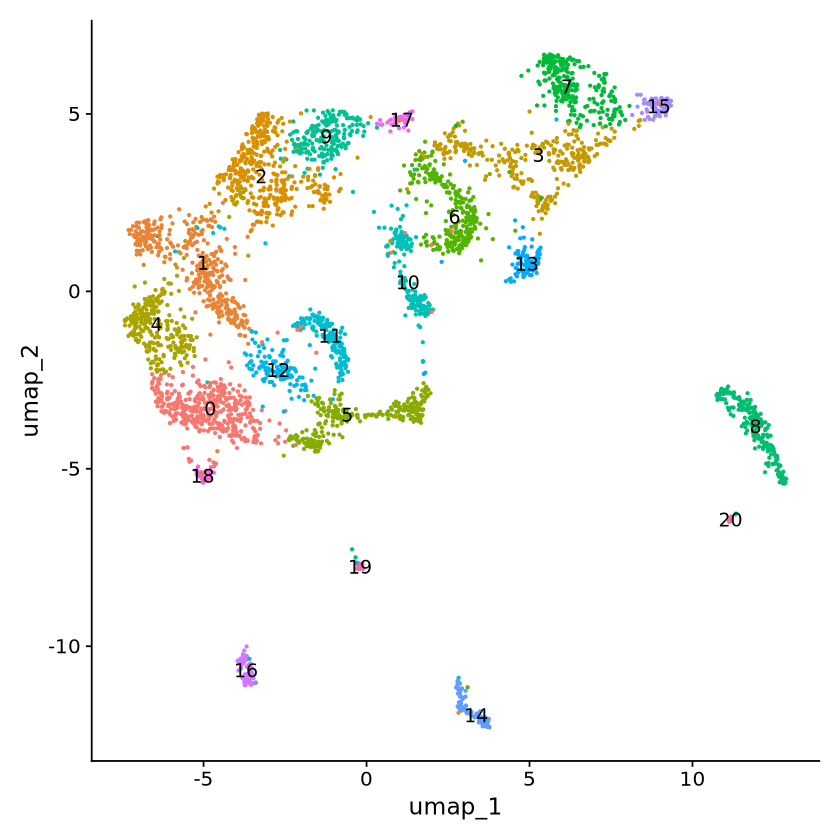

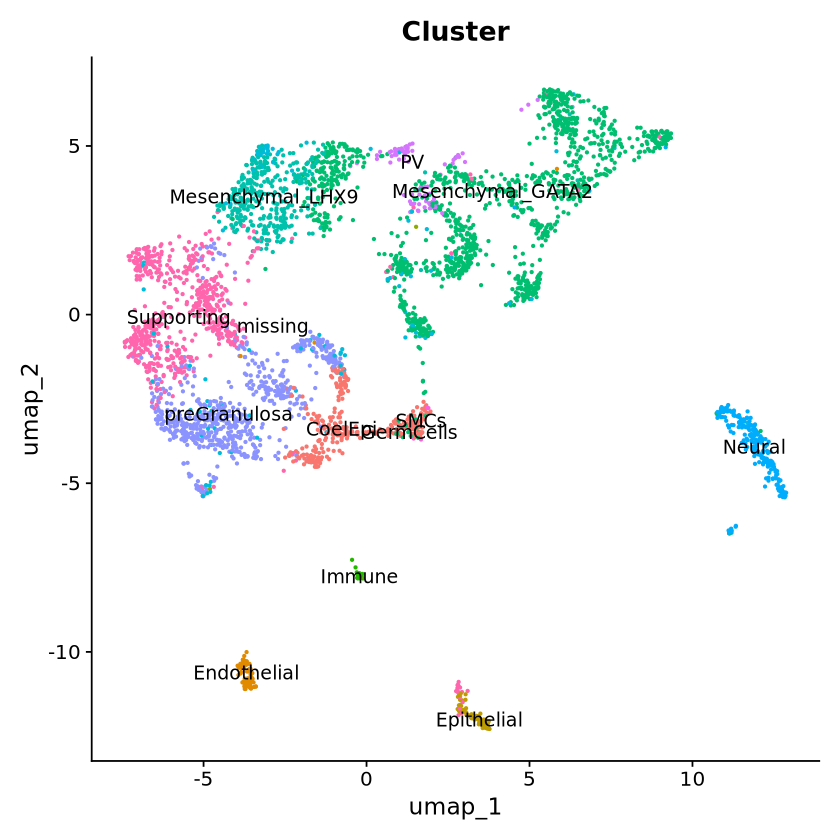

In [13]:
# UMAPs
seurat_obj <- RunUMAP(object = seurat_obj, reduction = 'lsi', dims = 2:30)
seurat_obj <- FindNeighbors(object = seurat_obj, reduction = 'lsi', dims = 2:30)
seurat_obj <- FindClusters(object = seurat_obj, verbose = FALSE, algorithm = 3)
DimPlot(object = seurat_obj, label = TRUE) + NoLegend()


library(ggplot2)

plot1 <- DimPlot(
  object = seurat_obj,
  group.by = 'cell_type',
  label = TRUE) + NoLegend() + ggtitle('Cluster')
plot1

## Integration with scRNA 

Validating h5Seurat file

Initializing RNA with data

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the SeuratDisk package.
  Please report the issue at
  <https://github.com/mojaveazure/seurat-disk/issues>.”
Adding counts for RNA

Warning message:
“The `slot` argument of `SetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the SeuratDisk package.
  Please report the issue at
  <https://github.com/mojaveazure/seurat-disk/issues>.”
Adding feature-level metadata for RNA

Adding reduction scVI

Adding cell embeddings for scVI

Adding miscellaneous information for scVI

Adding reduction umap

Adding cell embeddings for umap

Adding miscellaneous information for umap

Adding command information

Adding cell-level metadata

Adding miscellaneous information

Adding t

An object of class Seurat 
28820 features across 133811 samples within 1 assay 
Active assay: RNA (28820 features, 0 variable features)
 2 layers present: counts, data
 2 dimensional reductions calculated: scVI, umap

An object of class Seurat 
28820 features across 213898 samples within 1 assay 
Active assay: RNA (28820 features, 0 variable features)
 2 layers present: counts, data
 2 dimensional reductions calculated: scVI, umap

An object of class Seurat 
28820 features across 213898 samples within 1 assay 
Active assay: RNA (28820 features, 0 variable features)
 2 layers present: counts, data
 2 dimensional reductions calculated: scVI, umap

Extracting gene coordinates

Warning message in SingleFeatureMatrix(fragment = fragments[[x]], features = features, :
“13 features are on seqnames not present in the fragment file. These will be removed.”
Extracting reads overlapping genomic regions

Warning message in SingleFeatureMatrix(fragment = fragments[[x]], features = features, :
“13 features are on seqnames not present in the fragment file. These will be removed.”
Extracting reads overlapping genomic regions

Warning message in SingleFeatureMatrix(fragment = fragments[[x]], features = features, :
“13 features are on seqnames not present in the fragment file. These will be removed.”
Extracting reads overlapping genomic regions

Warning message:
“The `slot` argument of `FetchData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Running CCA

Merging object

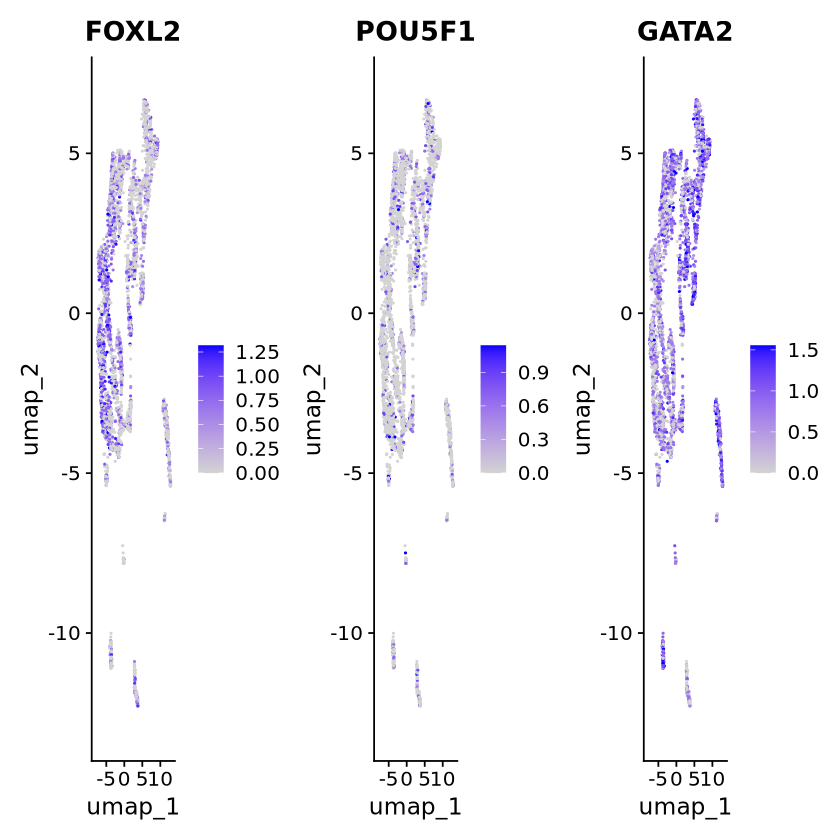

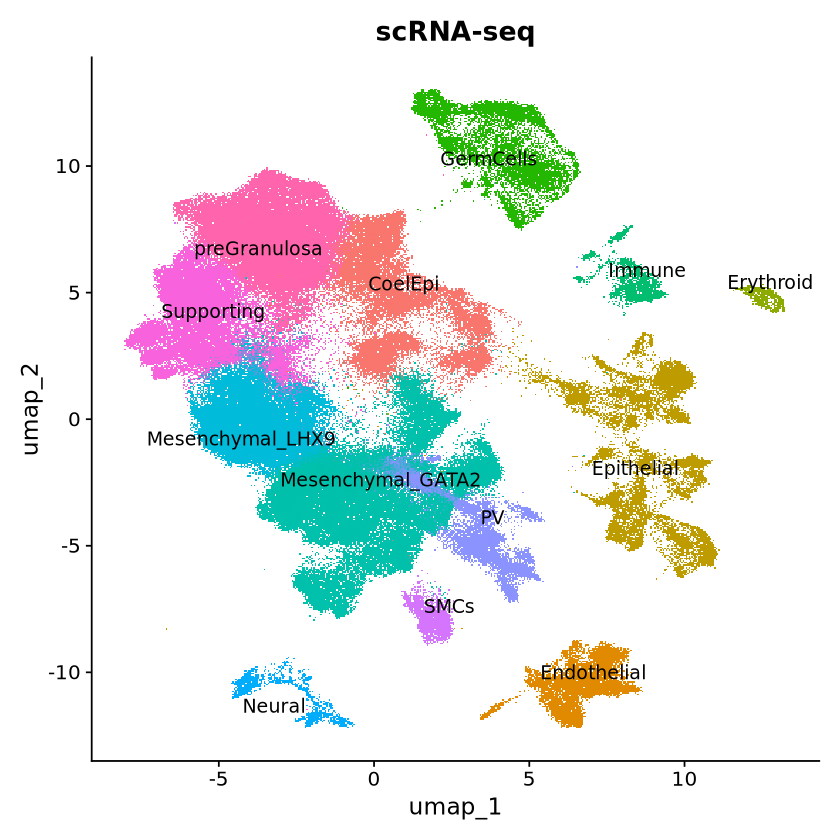

In [4]:
library(Signac)
library(Seurat)
library(GenomicRanges)
library(Matrix)
library(future)
library(AnnotationHub)
library(irlba)
library(SeuratDisk)



# Step 2: Load into Seurat
male_scrna <- LoadH5Seurat("human_main_male.h5seurat")
female_scrna <- LoadH5Seurat("human_main_female.h5seurat")

male_scrna
female_scrna
# decide on which scrna to run:
if (gender == "female") {
  scrna_obj <- female_scrna
  gene_lst <- c('FOXL2', 'POU5F1', 'GATA2' )
  
} else if (gender == "male") {
  scrna_obj <- male_scrna
  gene_lst <- c('SOX9', 'POU5F1', 'HSD3B2', 'GATA2')
} else {
  stop("Invalid gender. Must be 'male' or 'female'.")
}


scrna_obj

gene.activities <- GeneActivity(seurat_obj)


# add the gene activity matrix to the Seurat object as a new assay and normalize it
seurat_obj[['RNA']] <- CreateAssayObject(counts = gene.activities)
seurat_obj <- NormalizeData(
  object = seurat_obj,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(seurat_obj$nCount_RNA)
)


DefaultAssay(seurat_obj) <- 'RNA'

FeaturePlot(
  object = seurat_obj,
  features = gene_lst ,
  pt.size = 0.1,
  max.cutoff = 'q95',
  ncol = 3
)


# add anchor
seurat_obj <- FindVariableFeatures(seurat_obj)
scrna_obj <- FindVariableFeatures(scrna_obj)


# find a list of marker genes
# Idents(scrna_obj) <- scrna_obj$lineage
# table(Idents(scrna_obj))  # Make sure the groups exist

# markers <- FindAllMarkers(scrna_obj)
# markers


transfer.anchors <- FindTransferAnchors(
  reference = scrna_obj,
  query = seurat_obj,
  reduction = 'cca'
)


predicted.labels <- TransferData(
  anchorset = transfer.anchors,
  refdata = scrna_obj$lineage,
  weight.reduction = seurat_obj[['lsi']],
  dims = 2:30
)


seurat_obj <- AddMetaData(object = seurat_obj, metadata = predicted.labels)

plot1 <- DimPlot(
  object = scrna_obj,
  group.by = 'lineage',
  label = TRUE,
  repel = TRUE) + NoLegend() + ggtitle('scRNA-seq')

plot2 <- DimPlot(
  object = seurat_obj,
  group.by = 'predicted.id',
  label = TRUE,
  repel = TRUE) + NoLegend() + ggtitle('scATAC-seq')

plot1 

In [ ]:
plot2

In [ ]:
for (gene in gene_lst) {
  print(FeaturePlot(scrna_obj, features = gene, reduction = "umap", label = TRUE) + ggtitle(gene))
}


In [ ]:
for (gene in gene_lst) {
  print(FeaturePlot(seurat_obj, features = gene, reduction = "umap", label = TRUE) + ggtitle(gene))
}


In [ ]:
DimPlot(seurat_obj, reduction = "umap", group.by = "cell_type", label = TRUE)
DimPlot(seurat_obj, reduction = "umap", group.by = "predicted.id", label = TRUE)

In [ ]:
# # get the gene expression
# # for female
# # Export raw RNA counts
# write.csv(as.matrix(GetAssayData(female_scrna, assay = "RNA", slot = "counts")),
#           file = "rna_counts_raw.csv")

# # Export normalized RNA expression (log-normalized by default)
# write.csv(as.matrix(GetAssayData(female_scrna, assay = "RNA", slot = "data")),
#           file = "rna_expression_normalized.csv")


# # for male
# write.csv(as.matrix(GetAssayData(male_scrna, assay = "RNA", slot = "counts")),
#           file = "rna_counts_raw.csv")

# # Export normalized RNA expression (log-normalized by default)
# write.csv(as.matrix(GetAssayData(male_scrna, assay = "RNA", slot = "data")),
#           file = "rna_expression_normalized.csv")




In [ ]:
# # for female
# if (gender == "female") {
#   write.csv(as.matrix(GetAssayData(seurat_obj[["RNA"]], slot = "counts")),
#             file = "gene_activity_raw_female.csv")
#   write.csv(as.matrix(GetAssayData(seurat_obj[["RNA"]], slot = "data")),
#             file = "gene_activity_normalized_female.csv")
# } else if (gender == "male"){
#   write.csv(as.matrix(GetAssayData(seurat_obj[["RNA"]], slot = "counts")),
#             file = "gene_activity_raw_male.csv")
#   write.csv(as.matrix(GetAssayData(seurat_obj[["RNA"]], slot = "data")),
#             file = "gene_activity_normalized_male.csv")
#     }



# Code for running Hieu's Pipeline

### Scores for row-wise

In [14]:
# library(Matrix)
# library(dplyr)

# # 1. Extract data
# counts_matrix <- seurat_obj[["ATAC"]]@counts   # sparse matrix: features x cells
# cell_types <- seurat_obj@meta.data$cell_type
# names(cell_types) <- colnames(seurat_obj)      # map cell names to cell types

# # 2. Create a mapping from columns (cells) to their cell types
# cell_type_vec <- cell_types[colnames(counts_matrix)]

# # 3. For each feature, count nonzero entries per cell type
# feature_counts_by_type <- apply(counts_matrix, 1, function(x) {
#   active_cells <- which(x != 0)
#   active_cell_types <- cell_type_vec[active_cells]
#   tab <- table(active_cell_types)
#   return(tab)
# })

# # 4. Combine into data.frame
# # (transpose, fill NAs, and add feature names)
# df <- do.call(rbind, lapply(feature_counts_by_type, function(x) as.data.frame(as.list(x))))
# df[is.na(df)] <- 0

# # 5. Add feature name as row
# df$feature <- rownames(counts_matrix)
# df <- df[, c("feature", setdiff(colnames(df), "feature"))]

# # 6. Optional: Split feature into chr-start-end if needed
# df <- df %>%
#   tidyr::separate(feature, into = c("chr", "start", "end"), sep = "[-:]") %>%
#   relocate(chr, start, end)

# # View result
# head(df)
library(Matrix)
library(dplyr)
library(tidyr)

# 1. Extract data
counts_matrix <- seurat_obj[["ATAC"]]@counts   # sparse Matrix (dgCMatrix)
cell_types <- seurat_obj@meta.data$cell_type
names(cell_types) <- colnames(seurat_obj)

# 2. Map each column index to its cell type
cell_type_vec <- cell_types[colnames(counts_matrix)]

# 3. Use sparseMatrix to compute cell-type sums per feature
# Convert sparse matrix to triplet format
triplet <- summary(counts_matrix)  # gives i (row), j (col), x (value)

# Map j (cell index) to cell type
triplet$cell_type <- cell_type_vec[triplet$j]

# Make feature ID for output (e.g., rownames: chr-start-end)
feature_names <- rownames(counts_matrix)
triplet$feature <- feature_names[triplet$i]

# 4. Aggregate: count non-zero per feature per cell type
# df <- triplet %>%
#   filter(x != 0) %>%
#   count(feature, cell_type, name = "count") %>%
#   pivot_wider(names_from = cell_type, values_from = count, values_fill = 0)
df <- triplet %>%
  dplyr::filter(x != 0) %>%
  dplyr::count(feature, cell_type, name = "count") %>%
  tidyr::pivot_wider(names_from = cell_type, values_from = count, values_fill = 0)

# 5. Optionally split feature into chr, start, end
df <- df %>%
  separate(feature, into = c("chr", "start", "end"), sep = "[-:]", convert = TRUE) %>%
  relocate(chr, start, end)

head(df)
dim(df)



Attaching package: 'tidyr'


The following objects are masked from 'package:Matrix':

    expand, pack, unpack


The following object is masked from 'package:S4Vectors':

    expand




chr,start,end,CoelEpi,Mesenchymal_GATA2,Mesenchymal_LHX9,Neural,PV,Supporting,Endothelial,Epithelial,Immune,SMCs,missing,preGranulosa,GermCells
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1,10001016,10001285,3,14,1,2,1,2,0,0,0,0,0,0,0
chr1,100034406,100040189,156,612,198,85,32,286,42,34,11,1,48,293,0
chr1,100041785,100041860,2,3,2,0,0,1,0,0,0,0,0,5,0
chr1,100048829,100048940,1,2,0,0,0,0,0,0,0,0,0,1,0
chr1,10007165,10007808,3,36,6,3,0,10,2,0,0,0,3,12,0
chr1,100127195,100127928,1,5,4,0,2,28,0,0,0,0,2,5,0


[1] 202585     16

In [16]:
library(dplyr)
library(tidyr)

# Step 3: Map to short form
map_dict <- c(
  "Mesenchymal_LHX9"    = "MesLHX9",
  "Mesenchymal_GATA2"   = "MesGATA2",
  "Supporting"          = "Supp",
  "preGranulosa"        = "preGran",
  "missing"             = "Missing",
  "Endothelial"         = "Endo",
  "PV"                  = "PV",
  "CoelEpi"             = "CoelEpi",
  "Epithelial"          = "Epi",
  "Neural"              = "Neuro",
  "Immune"              = "Immune",
  "GermCells"           = "Germ",
  "SMCs"                = "SMC"
)

# Define the exact desired order
ordered_celltypes = c(
    "Supp",
    "MesLHX9",
    "Epi",
    "Endo",
    "Neuro",
    "Missing",
    "MesGATA2",
    "preGran",
    "PV",
    "CoelEpi",
    "Immune",
    "Germ",
    "SMC"
)

# df_long <- df %>%
#   pivot_longer(-c(chr, start, end), names_to = "cell_type", values_to = "count") %>%
#   filter(count > 0) %>%
#   mutate(short = map_dict[cell_type]) %>%
#   filter(!is.na(short)) %>%
#   mutate(tag = paste0(short, "_", count))  # change here

# df_final <- df_long %>%
#   mutate(short = factor(short, levels = ordered_celltypes)) %>%
#   arrange(chr, start, end, short) %>%
#   group_by(chr, start, end) %>%
#   summarise(celltype_string = paste(tag, collapse = "_"), .groups = "drop")  # change here

# df_final %>% filter(start == 100034406)

df_long <- df %>%
  tidyr::pivot_longer(-c(chr, start, end), names_to = "cell_type", values_to = "count") %>%
  dplyr::filter(count > 0) %>%
  dplyr::mutate(short = map_dict[cell_type]) %>%
  dplyr::filter(!is.na(short)) %>%
  dplyr::mutate(tag = paste0(short, "_", count))

df_final <- df_long %>%
  dplyr::mutate(short = factor(short, levels = ordered_celltypes)) %>%
  dplyr::arrange(chr, start, end, short) %>%
  dplyr::group_by(chr, start, end) %>%
  dplyr::summarise(celltype_string = paste(tag, collapse = "_"), .groups = "drop")

df_final %>% dplyr::filter(start == 100034406)

head(df)
head(df_final)



chr,start,end,celltype_string
<chr>,<int>,<int>,<chr>
chr1,100034406,100040189,Supp_286_MesLHX9_198_Epi_34_Endo_42_Neuro_85_Missing_48_MesGATA2_612_preGran_293_PV_32_CoelEpi_156_Immune_11_SMC_1


chr,start,end,CoelEpi,Mesenchymal_GATA2,Mesenchymal_LHX9,Neural,PV,Supporting,Endothelial,Epithelial,Immune,SMCs,missing,preGranulosa,GermCells
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1,10001016,10001285,3,14,1,2,1,2,0,0,0,0,0,0,0
chr1,100034406,100040189,156,612,198,85,32,286,42,34,11,1,48,293,0
chr1,100041785,100041860,2,3,2,0,0,1,0,0,0,0,0,5,0
chr1,100048829,100048940,1,2,0,0,0,0,0,0,0,0,0,1,0
chr1,10007165,10007808,3,36,6,3,0,10,2,0,0,0,3,12,0
chr1,100127195,100127928,1,5,4,0,2,28,0,0,0,0,2,5,0


chr,start,end,celltype_string
<chr>,<int>,<int>,<chr>
chr1,10127,10410,Supp_5_MesLHX9_3_Epi_1_Endo_4_Neuro_6_Missing_3_MesGATA2_12_preGran_3_PV_3_CoelEpi_3
chr1,180680,181688,Supp_20_MesLHX9_6_Epi_2_Endo_6_Neuro_8_Missing_3_MesGATA2_38_preGran_11_PV_2_CoelEpi_7_Germ_1
chr1,191342,191613,MesLHX9_3_Endo_2_Neuro_10_Missing_1_MesGATA2_4_preGran_1_PV_1
chr1,267775,268232,Supp_15_MesLHX9_6_Epi_1_Neuro_4_Missing_2_MesGATA2_8_preGran_13_CoelEpi_5
chr1,585990,586417,Supp_13_MesLHX9_3_Endo_1_Neuro_3_Missing_2_MesGATA2_7_preGran_13_CoelEpi_4_SMC_1
chr1,629707,630804,Supp_81_MesLHX9_39_Epi_9_Endo_5_Neuro_14_Missing_11_MesGATA2_80_preGran_63_PV_4_CoelEpi_38_SMC_2


In [17]:
library(dplyr)

aggregated <- df_final %>%
  rename(aggregated_cell_type = celltype_string) 

head(aggregated)
dim(aggregated)

chr,start,end,aggregated_cell_type
<chr>,<int>,<int>,<chr>
chr1,10127,10410,Supp_5_MesLHX9_3_Epi_1_Endo_4_Neuro_6_Missing_3_MesGATA2_12_preGran_3_PV_3_CoelEpi_3
chr1,180680,181688,Supp_20_MesLHX9_6_Epi_2_Endo_6_Neuro_8_Missing_3_MesGATA2_38_preGran_11_PV_2_CoelEpi_7_Germ_1
chr1,191342,191613,MesLHX9_3_Endo_2_Neuro_10_Missing_1_MesGATA2_4_preGran_1_PV_1
chr1,267775,268232,Supp_15_MesLHX9_6_Epi_1_Neuro_4_Missing_2_MesGATA2_8_preGran_13_CoelEpi_5
chr1,585990,586417,Supp_13_MesLHX9_3_Endo_1_Neuro_3_Missing_2_MesGATA2_7_preGran_13_CoelEpi_4_SMC_1
chr1,629707,630804,Supp_81_MesLHX9_39_Epi_9_Endo_5_Neuro_14_Missing_11_MesGATA2_80_preGran_63_PV_4_CoelEpi_38_SMC_2


[1] 202585      4

In [18]:
# ovary_bed_file = "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas/scores_q75_week_7_9_ovary_bed_file.bed"
library(glue)
weeks_str <- paste(chosen_weeks, collapse = "_")
file_name <- glue("scores_q75_week_{weeks_str}_{gender}_bed_file.bed")
dir_path <- "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas"
file_path <- file.path(dir_path, file_name)
ovary_bed_file <- file_path

write.table(
  aggregated,
  file = ovary_bed_file,
  sep = "\t",
  quote = FALSE,
  row.names = FALSE,
  col.names = FALSE
)




Attaching package: 'glue'


The following object is masked from 'package:GenomicRanges':

    trim


The following object is masked from 'package:IRanges':

    trim




In [21]:
# map_dict <- c(
#   "Mesenchymal_LHX9"    = "MesLHX9",
#   "Mesenchymal_GATA2"   = "MesGATA2",
#   "Supporting"          = "Supp",
#   "preGranulosa"        = "preGran",
#   "missing"             = "Missing",
#   "Endothelial"         = "Endo",
#   "PV"                  = "PV",
#   "CoelEpi"             = "CoelEpi",
#   "Epithelial"          = "Epi",
#   "Neural"              = "Neuro",
#   "Immune"              = "Immune",
#   "GermCells"           = "Germ",
#   "SMCs"                = "SMC"
# )


# # Function to map all comma-separated values
# shorten_labels <- function(s) {
#   cell_types <- unlist(strsplit(s, ","))
#   mapped <- map_dict[cell_types]
#   final_label <- paste(c("ovary", mapped), collapse = "_")
#   return(final_label)
# }


# counts_matrix <- seurat_obj[["ATAC"]]@counts
# # as.vector(counts_matrix[2, ])
# cell_types <- seurat_obj@meta.data$cell_type


# # chr1-10127-10410: 4000 --> 43
# # which(counts_matrix[2, ] == 1)
# cell_barcodes <- colnames(counts_matrix)[which(counts_matrix[1, ] == 1)]
# length(cell_barcodes)
# cell_barcodes
# metadata <- seurat_obj@meta.data
# unique(metadata[cell_barcodes, "cell_type"])


# cell_types <- seurat_obj@meta.data$cell_type
# names(cell_types) <- colnames(seurat_obj)
# counts_matrix <- seurat_obj[["ATAC"]]@counts

# # Convert sparse matrix to triplet format
# counts_triplet <- summary(counts_matrix)  # data.frame with i, j, x

# # Map column indices (cells) to cell types
# cell_names <- colnames(counts_matrix)
# counts_triplet$cell <- cell_names[counts_triplet$j]
# counts_triplet$cell_type <- cell_types[counts_triplet$cell]

# # Map row indices to peak names
# peak_names <- rownames(counts_matrix)
# counts_triplet$peak <- peak_names[counts_triplet$i]

# # Aggregate: list of cell types per peak
# library(dplyr)

# aggregated <- counts_triplet %>%
#   group_by(peak) %>%
#   summarise(aggregated_cell_type = paste(unique(cell_type), collapse = ",")) %>%
#   as.data.frame()

# shorten_labels("CoelEpi,Mesenchymal_GATA2,Mesenchymal_LHX9,Supporting,PV,Neural")



# # Step 1: Split peak into chr, start, end
# peak_split <- do.call(rbind, strsplit(aggregated$peak, "-"))
# aggregated$chr <- peak_split[,1]
# aggregated$start <- as.integer(peak_split[,2])
# aggregated$end <- as.integer(peak_split[,3])



# # Step 3: Map to short form

# aggregated$aggregated_cell_type <- sapply(aggregated$aggregated_cell_type, shorten_labels)




# # Final dataframe
# aggregated <- aggregated[, c("chr", "start", "end", "aggregated_cell_type")]
# names(aggregated)[names(aggregated) == "aggregated_cell_type"] <- "cell_type"
# head(aggregated)

# # chr, start, end, tissue, cell_type (_):  E.g: ovary_granulosa_coelepi



# dim(aggregated)



In [22]:
seurat_obj

An object of class Seurat 
202606 features across 3893 samples within 1 assay 
Active assay: ATAC (202606 features, 50735 variable features)
 2 layers present: counts, data
 2 dimensional reductions calculated: lsi, umap

In [23]:


# doesn't really need this
# main difference between this pipeline and Signac_merge_pipeline and Draft.ipynb


# be aware of yourself when running this pipeline
# Load variable features
var_peaks <- VariableFeatures(seurat_obj)

# Convert "chr15-75449339-75457073" to a data frame with chr, start, end
library(dplyr)
library(tidyr)

peak_df <- data.frame(peak = var_peaks) %>%
  separate(peak, into = c("chr", "start", "end"), sep = "-", convert = TRUE)

head(peak_df)
# Read the BED file, this is from Hieu's input
# ovary_bed_file = "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas/ovary_bed_file.bed"
library(glue)
weeks_str <- paste(chosen_weeks, collapse = "_")
file_name <- glue("scores_q75_week_{weeks_str}_{gender}_bed_file.bed")
dir_path <- "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas"
file_path <- file.path(dir_path, file_name)
ovary_bed_file <- file_path


bed <- read.table(ovary_bed_file, header = FALSE, sep = "\t", stringsAsFactors = FALSE)
colnames(bed)[1:3] <- c("chr", "start", "end")

# Inner join to get matching peaks
filtered_bed <- inner_join(bed, peak_df, by = c("chr", "start", "end"))

# View result
head(filtered_bed)
dim(filtered_bed)

# # # Optionally save it
# filtered_bed_file = "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas/q75_filtered_ovary_bed_file.bed"

# write.table(filtered_bed, filtered_bed_file,
#             sep = "\t", row.names = FALSE, col.names = FALSE, quote = FALSE)

# q0: 181870
# q25: 137074
# q50: 91051
# q75: 45504
# q90: 18190


,chr,start,end
,<chr>,<int>,<int>
1,chr15,75449339,75457073
2,chr19,54186335,54192496
3,chr13,110711287,110718395
4,chr14,75276368,75285398
5,chr19,13148741,13158539
6,chr19,12787585,12797555


,chr,start,end,V4
,<chr>,<int>,<int>,<chr>
1,chr1,629707,630804,Supp_81_MesLHX9_39_Epi_9_Endo_5_Neuro_14_Missing_11_MesGATA2_80_preGran_63_PV_4_CoelEpi_38_SMC_2
2,chr1,633783,634573,Supp_168_MesLHX9_54_Epi_21_Endo_7_Neuro_44_Missing_18_MesGATA2_222_preGran_135_PV_17_CoelEpi_81_Immune_2
3,chr1,778114,779576,Supp_237_MesLHX9_127_Epi_26_Endo_32_Neuro_102_Missing_46_MesGATA2_457_preGran_237_PV_38_CoelEpi_102_Immune_14_Germ_1_SMC_2
4,chr1,825768,827942,Supp_135_MesLHX9_43_Epi_13_Endo_21_Neuro_59_Missing_18_MesGATA2_171_preGran_128_PV_15_CoelEpi_47_Immune_8
5,chr1,869499,870392,Supp_59_MesLHX9_28_Epi_18_Endo_16_Neuro_42_Missing_13_MesGATA2_95_preGran_82_PV_3_CoelEpi_35_Immune_2
6,chr1,874955,877774,Supp_47_MesLHX9_26_Epi_3_Endo_4_Neuro_5_Missing_8_MesGATA2_98_preGran_35_PV_6_CoelEpi_21_Immune_1


[1] 50735     4

In [24]:
library(glue)
weeks_str <- paste(chosen_weeks, collapse = "_")
file_name <- glue("scores_q75_filtered_week_{weeks_str}_{gender}_bed_file.bed")
dir_path <- "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas"
file_path <- file.path(dir_path, file_name)
filtered_bed_file <- file_path

write.table(filtered_bed, filtered_bed_file,
            sep = "\t", row.names = FALSE, col.names = FALSE, quote = FALSE)

In [ ]:
# # ovary_bed_file = "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas/ovary_bed_file.bed"


# write.table(
#   aggregated,
#   file = ovary_bed_file,
#   sep = "\t",
#   quote = FALSE,
#   row.names = FALSE,
#   col.names = FALSE
# )


### Peak files for working with Hieu's input

In [34]:
seurat_obj


An object of class Seurat 
202606 features across 3893 samples within 1 assay 
Active assay: ATAC (202606 features, 50735 variable features)
 2 layers present: counts, data
 2 dimensional reductions calculated: lsi, umap

In [35]:
# normalize --> threshold (0.95 e.g)

# for each combination of 

# for each cell type: how many cell type combination does this cell type dominate

cell_types <- seurat_obj@meta.data$cell_type
names(cell_types) <- colnames(seurat_obj)
counts_matrix <- seurat_obj[["ATAC"]]@counts


# Convert sparse matrix to triplet format
counts_triplet <- summary(counts_matrix)  # data.frame with i, j, x

# Map column indices (cells) to cell types
cell_names <- colnames(counts_matrix)
counts_triplet$cell <- cell_names[counts_triplet$j]
counts_triplet$cell_type <- cell_types[counts_triplet$cell]

# Map row indices to peak names
peak_names <- rownames(counts_matrix)
counts_triplet$peak <- peak_names[counts_triplet$i]

# Aggregate: list of cell types per peak
library(dplyr)

aggregated <- counts_triplet %>%
  group_by(peak) %>%
  summarise(aggregated_cell_type = paste(unique(cell_type), collapse = ",")) %>%
  as.data.frame()


In [36]:
head(aggregated)


,peak,aggregated_cell_type
,<chr>,<chr>
1,chr1-10001016-10001285,"CoelEpi,Mesenchymal_GATA2,Mesenchymal_LHX9,Supporting,PV,Neural"
2,chr1-100034406-100040189,"Mesenchymal_LHX9,preGranulosa,Mesenchymal_GATA2,CoelEpi,Supporting,Endothelial,PV,missing,Epithelial,Neural,Immune,SMCs"
3,chr1-100041785-100041860,"Mesenchymal_LHX9,Mesenchymal_GATA2,preGranulosa,CoelEpi,Supporting"
4,chr1-100048829-100048940,"Mesenchymal_GATA2,preGranulosa,CoelEpi"
5,chr1-10007165-10007808,"Mesenchymal_LHX9,CoelEpi,Supporting,preGranulosa,missing,Endothelial,Mesenchymal_GATA2,Neural"
6,chr1-100127195-100127928,"Supporting,Mesenchymal_LHX9,Mesenchymal_GATA2,CoelEpi,preGranulosa,PV,missing"


In [37]:
# Step 1: Split peak into chr, start, end
peak_split <- do.call(rbind, strsplit(aggregated$peak, "-"))
aggregated$chr <- peak_split[,1]
aggregated$start <- as.integer(peak_split[,2])
aggregated$end <- as.integer(peak_split[,3])



# Step 3: Map to short form
map_dict <- c(
  "Mesenchymal_LHX9"    = "MesLHX9",
  "Mesenchymal_GATA2"   = "MesGATA2",
  "Supporting"          = "Supp",
  "preGranulosa"        = "preGran",
  "missing"             = "Missing",
  "Endothelial"         = "Endo",
  "PV"                  = "PV",
  "CoelEpi"             = "CoelEpi",
  "Epithelial"          = "Epi",
  "Neural"              = "Neuro",
  "Immune"              = "Immune",
  "GermCells"           = "Germ",
  "SMCs"                = "SMC",
  "Sertoli"             = "Sertoli",
  "Erythroid"           = "Eryth",
  "FetalLeydig"         = "FLeydig"
)


# Function to map all comma-separated values
shorten_labels <- function(s) {
  cell_types <- unlist(strsplit(s, ","))
  mapped <- map_dict[cell_types]
  final_label <- paste(c("ovary", mapped), collapse = "_")
  return(final_label)
}

aggregated$aggregated_cell_type <- sapply(aggregated$aggregated_cell_type, shorten_labels)




# Final dataframe
aggregated <- aggregated[, c("chr", "start", "end", "aggregated_cell_type")]
names(aggregated)[names(aggregated) == "aggregated_cell_type"] <- "cell_type"
head(aggregated)
dim(aggregated)
# chr, start, end, tissue, cell_type (_):  E.g: ovary_granulosa_coelepi

,chr,start,end,cell_type
,<chr>,<int>,<int>,<chr>
1,chr1,10001016,10001285,ovary_CoelEpi_MesGATA2_MesLHX9_Supp_PV_Neuro
2,chr1,100034406,100040189,ovary_MesLHX9_preGran_MesGATA2_CoelEpi_Supp_Endo_PV_Missing_Epi_Neuro_Immune_SMC
3,chr1,100041785,100041860,ovary_MesLHX9_MesGATA2_preGran_CoelEpi_Supp
4,chr1,100048829,100048940,ovary_MesGATA2_preGran_CoelEpi
5,chr1,10007165,10007808,ovary_MesLHX9_CoelEpi_Supp_preGran_Missing_Endo_MesGATA2_Neuro
6,chr1,100127195,100127928,ovary_Supp_MesLHX9_MesGATA2_CoelEpi_preGran_PV_Missing


[1] 202585      4

In [38]:
# testes_bed_file = "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas/q75_week_7_9_testes_bed_file.bed"
library(glue)
weeks_str <- paste(chosen_weeks, collapse = "_")
file_name <- glue("q75_week_{weeks_str}_{gender}_bed_file.bed")
dir_path <- "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas"
file_path <- file.path(dir_path, file_name)

ovary_bed_file <- file_path
print(ovary_bed_file)

write.table(
  aggregated,
  file = ovary_bed_file,
  sep = "\t",
  quote = FALSE,
  row.names = FALSE,
  col.names = FALSE
)



[1] "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas/q75_week_8.6_8.8_9_female_bed_file.bed"


In [39]:

# be aware of yourself when running this pipeline
# Load variable features
var_peaks <- VariableFeatures(seurat_obj)

# Convert "chr15-75449339-75457073" to a data frame with chr, start, end
library(dplyr)
library(tidyr)

peak_df <- data.frame(peak = var_peaks) %>%
  separate(peak, into = c("chr", "start", "end"), sep = "-", convert = TRUE)

head(peak_df)
# Read the BED file, this is from Hieu's input
# ovary_bed_file = "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas/scores_q75_week_7_9_testes_bed_file.bed"
ovary_bed_file <- file_path
bed <- read.table(ovary_bed_file, header = FALSE, sep = "\t", stringsAsFactors = FALSE)
colnames(bed)[1:3] <- c("chr", "start", "end")

# Inner join to get matching peaks
filtered_bed <- inner_join(bed, peak_df, by = c("chr", "start", "end"))

# View result
head(filtered_bed)
dim(filtered_bed)



,chr,start,end
,<chr>,<int>,<int>
1,chr15,75449339,75457073
2,chr19,54186335,54192496
3,chr13,110711287,110718395
4,chr14,75276368,75285398
5,chr19,13148741,13158539
6,chr19,12787585,12797555


,chr,start,end,V4
,<chr>,<int>,<int>,<chr>
1,chr1,100034406,100040189,ovary_MesLHX9_preGran_MesGATA2_CoelEpi_Supp_Endo_PV_Missing_Epi_Neuro_Immune_SMC
2,chr1,100132201,100134031,ovary_preGran_Supp_MesLHX9_Endo_PV_MesGATA2_CoelEpi_Missing_Epi_Neuro_Immune_SMC_Germ
3,chr1,100188185,100189230,ovary_MesLHX9_MesGATA2_Missing_Supp_preGran_CoelEpi_PV_Epi_Neuro_Immune_Endo
4,chr1,100248816,100250672,ovary_MesGATA2_preGran_MesLHX9_Endo_PV_Supp_CoelEpi_Missing_Neuro_Immune_Germ_Epi_SMC
5,chr1,100265343,100267433,ovary_MesLHX9_MesGATA2_CoelEpi_preGran_Supp_Missing_Endo_Epi_PV_Neuro_Immune_Germ
6,chr1,1002991,1007037,ovary_MesLHX9_MesGATA2_CoelEpi_Missing_Supp_Endo_preGran_PV_Epi_Neuro_Immune


[1] 50735     4

In [40]:

# # Optionally save it
# filtered_bed_file = "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas/scores_q75_filtered_week_7_9_testes_bed_file.bed"

weeks_str <- paste(chosen_weeks, collapse = "_")
file_name <- glue("q75_filtered_week_{weeks_str}_{gender}_bed_file.bed")
dir_path <- "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas"
file_path <- file.path(dir_path, file_name)
filtered_bed_file <- file_path

write.table(filtered_bed, filtered_bed_file,
            sep = "\t", row.names = FALSE, col.names = FALSE, quote = FALSE)

# q0: 181870
# q25: 137074
# q50: 91051
# q75: 45504 - 49084
# q90: 18190